# This notebook studies how the degree of connection in the network influences seeking performance.

In [97]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rc

import pickle as pkl
import networkx as nx
from functools import partial

import sys
sys.path.append('../')

from utils.dLdp import analytic_dLdp,analytic_dhdz,analytic_dhdq,analytic_FIM
from utils.ConsensusEKF import ConsensusEKF


from labellines import labelLine, labelLines

import time

SEED = 127547

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def single_meas_func(C1,C0,k,b,dist):
    return k*(dist-C1)**b+C0

def joint_meas_func(C1s,C0s,ks,bs,x,ps):

    # Casting for the compatibility of jax.numpy

    C1=np.array(C1s)
    C0=np.array(C0s)
    k=np.array(ks)
    b=np.array(bs)
    p=np.array(ps)

    # Keep in mind that x is a vector of [q,q'], thus only the first half of components are observable.    
    dists=np.linalg.norm(x[:len(x)//2]-p,axis=1)

    return single_meas_func(C1,C0,k,b,dists) 

# Distributed Experiment

In [98]:
import warnings
 
def random_connected_regular_graph(n,d,N_REPATS=1000):
    """
        Generate a connected random graph with n nodes, each with d neighbors.
    """
    assert(d<=n)
    if d == n:
        return nx.complete_graph(n)
    
    for _ in range(N_REPATS):
        G = nx.random_regular_graph(d,n)
        if nx.is_connected(G):
            return G
   
    # displaying the warning message 
    warnings.warn('A regular connected graph as specified is not found. Try increasing N_REPEATS or degree d.')

    return None
    

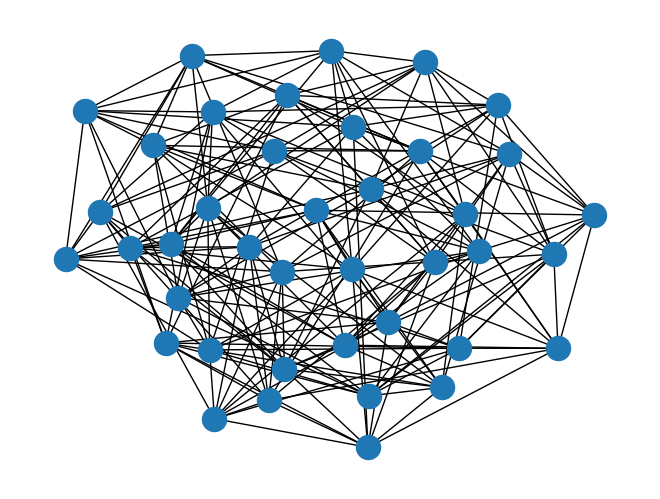

In [91]:
G = random_connected_regular_graph(40,10)
nx.draw(G)

In [93]:
nx.is_directed(G)

False

In [207]:
def distributed_main(N_trails,N_sen,N_iter,network_degree,qhat_0,consensus_est=True,coordinate=True,version='v1',FIM_cons_iter=10):
    '''Experiment Parameters'''

    comm_network_generator=lambda n:random_connected_regular_graph(n,d= network_degree)

    # The communication network and consensus weight matrix.
    G = comm_network_generator(N_sen)
    A = np.array(nx.adjacency_matrix(G).todense().astype(float))
    A +=np.eye(len(A))
    W = A/np.sum(A,axis=1) # The weight matrix required by parallel two-pass algorithm.

    # The step size of each sensor
    max_linear_speed=0.1
    
    # Set up virtual sensors
    C1=-0.3 # Setting C1 as a negative number mitigates the blowing-up effect when the sensors are close to the source.
    C0=0
    k=1
    b=-2
    noise_std = 0.01
    minimum_sensing_reading=1e-5
    
    # Consensus Gain
    C_gain = 0.1


    t=time.time()
    data={'p':[],'qhat':[],'q':[]}
    for _ in range(N_trails):

        '''Initialize Key Data Structures'''
        p_0 = (np.random.rand(N_sen,2)-0.5)*3
      
        p = np.array(p_0) # Sensor Positions
         
        q_0 = np.array([6,6])
        q = q_0 # Actual source location
        
        # qhat_0 = np.ones((N_sen,1)).dot(q_0.reshape(1,-1))
        # qhat_0+= (np.random.rand(*qhat_0.shape)-0.5)*D 
        
        qhat =  np.ones((N_sen,1)).dot(np.array(qhat_0).reshape(1,-1))
       

        def F_single(dh,qhat,ps):
            A = dh(qhat,ps)
            return A.T.dot(A)

        def joint_F_single(qhat,ps): # Verified to be correct.
            # The vectorized version of F_single.
            # The output shape is (N_sensor, q_dim, q_dim).
            # Where output[i]=F_single(dh,qhat,ps[i])
            A = analytic_dhdq(qhat,ps,C1s=C1,C0s=C0,ks=k,bs=b)
            return A[:,np.newaxis,:]*A[:,:,np.newaxis]


        # The list of single-term partial FIM's.
        F_0 = joint_F_single(qhat,p)
        F = np.array(F_0)

        # The list local estimate of global FIM.
        if version=='v1':
            F_est = F+1e-8*np.eye(2) # Adding a small I to ensure invertibility
        elif version=='v3':
            local_FIM = np.zeros(F.shape)
            for i in G.nodes():
                N_i = [i]+list(G[i]) 
                local_FIM[i,:,:]=analytic_FIM(qhat[N_i,:],p[N_i],C1,C0,k,b)
            F_est = local_FIM # v3: initialize F_est to be local FIMs.

        # The Consensus EKFs
        estimators = [ConsensusEKF(np.array(qhat_0),C_gain=C_gain) for _ in range(N_sen)]

        # The initialization of local measurement functions and the derivative functions. 
        # This is not very pretty. But is required by Consensus EKF.
        hs = []
        dhdzs = []
        dhdqs = []
        C1s=C1*np.ones(N_sen)
        C0s = C0*np.ones(N_sen)
        ks = k * np.ones(N_sen)
        bs = b*np.ones(N_sen)

        d = np.zeros(N_sen)
        for i in G.nodes():  
            N_i = [i]+list(G[i])     
            C1s_i=C1s[N_i]
            C0s_i = C0s[N_i]
            ks_i = ks[N_i]
            bs_i = bs[N_i]
            hs.append(partial(joint_meas_func,C1s_i,C0s_i,ks_i,bs_i))# Freeze the coefficients, the signature becomes h(z,ps))
            dhdzs.append(partial(analytic_dhdz,C1s=C1s_i,C0s=C0s_i,ks=ks_i,bs=bs_i))
            dhdqs.append(partial(analytic_dhdq,C1s=C1s_i,C0s=C0s_i,ks=ks_i,bs=bs_i))
            d[i]=len(N_i)

        # Variables for parallel two-pass algorithm.
        inv_d = 1/d
        w_F_est = F_est*inv_d[:,np.newaxis,np.newaxis]

        '''Main Loop'''

        p_history = []
        qhat_history = []
        q_history = []
        for _ in range(N_iter):
            # Measure
            r = np.linalg.norm(q-p,axis=1)
            y = k* ((r-C1)**b)+C0 + np.random.randn(N_sen)*noise_std
            y[y<=0]=minimum_sensing_reading # We don't want y to be zero or negative.


            # Estimate
            zhats = np.array([est.z for est in estimators])
            new_qhat = np.zeros(qhat.shape)
            local_FIM = np.zeros(F_est.shape)
            for i in G.nodes():
                N_i = [i]+list(G[i]) 
                # Estimate
                if consensus_est:
                    inv_d_neighbor=inv_d[N_i]
                else:
                    inv_d_neighbor=None
                new_qhat[i,:]=estimators[i].update_and_estimate_loc(hs[i],dhdzs[i],y[N_i],p[N_i],zhats[N_i])
                if not coordinate:
                    local_FIM[i,:,:]=analytic_FIM(qhat[N_i,:],p[N_i],C1,C0,k,b)

            qhat=new_qhat

            # Partial FIM Calculation and FIM consensus
            for _ in range(FIM_cons_iter):
                new_F = joint_F_single(qhat,p)
                dF = new_F-F
                F=new_F

                # FIM Consensus using parallel two-pass algorithm
                inv_d = W.dot(inv_d)
                w_F_est = (w_F_est.T.dot(W)).T + dF*inv_d[:,np.newaxis,np.newaxis]
                F_est = w_F_est/inv_d[:,np.newaxis,np.newaxis]   

            # Gradient update
            FIM_cand= F_est if coordinate else local_FIM
            for i in range(N_sen):
                dp=analytic_dLdp(qhat[i:i+1],p[i:i+1],C1,C0,k,b,FIM=FIM_cand[i])

                p[i:i+1]-=max_linear_speed*dp/np.linalg.norm(dp)

            # Record data
            p_history.append(np.array(p))
            qhat_history.append(np.array(qhat))
            q_history.append(np.array(q))

        data['p'].append(np.array(p_history))
        data['qhat'].append(np.array(qhat_history))
        data['q'].append(np.array(q_history))

    print('Time:',time.time()-t)
    return data

# Small Deviation in initial guess

In [252]:
network_degrees = [2,8,15]
# network_degrees = [2,4,8,10]
# network_degrees = [20]
N_trails = 5
N_iter=150
n_sen=20
data={}

qhat_0 = np.array([4,4])


np.random.seed(SEED)

for d in network_degrees:
    data[d] = distributed_main(N_trails,n_sen,N_iter,network_degree = d,qhat_0=qhat_0)

/var/folders/4v/bq7m33xj6b9fm2jfm0ngdg3c0000gn/T/ipykernel_19377/394059718.py:8: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = np.array(nx.adjacency_matrix(G).todense().astype(float))


Time: 1.518639087677002
Time: 3.173006057739258
Time: 3.2161381244659424


In [253]:
filepath = "../Data/Connectivity_DSmall.pkl".format(deviation)
with open(filepath,'wb') as file:
    pkl.dump(data,file)


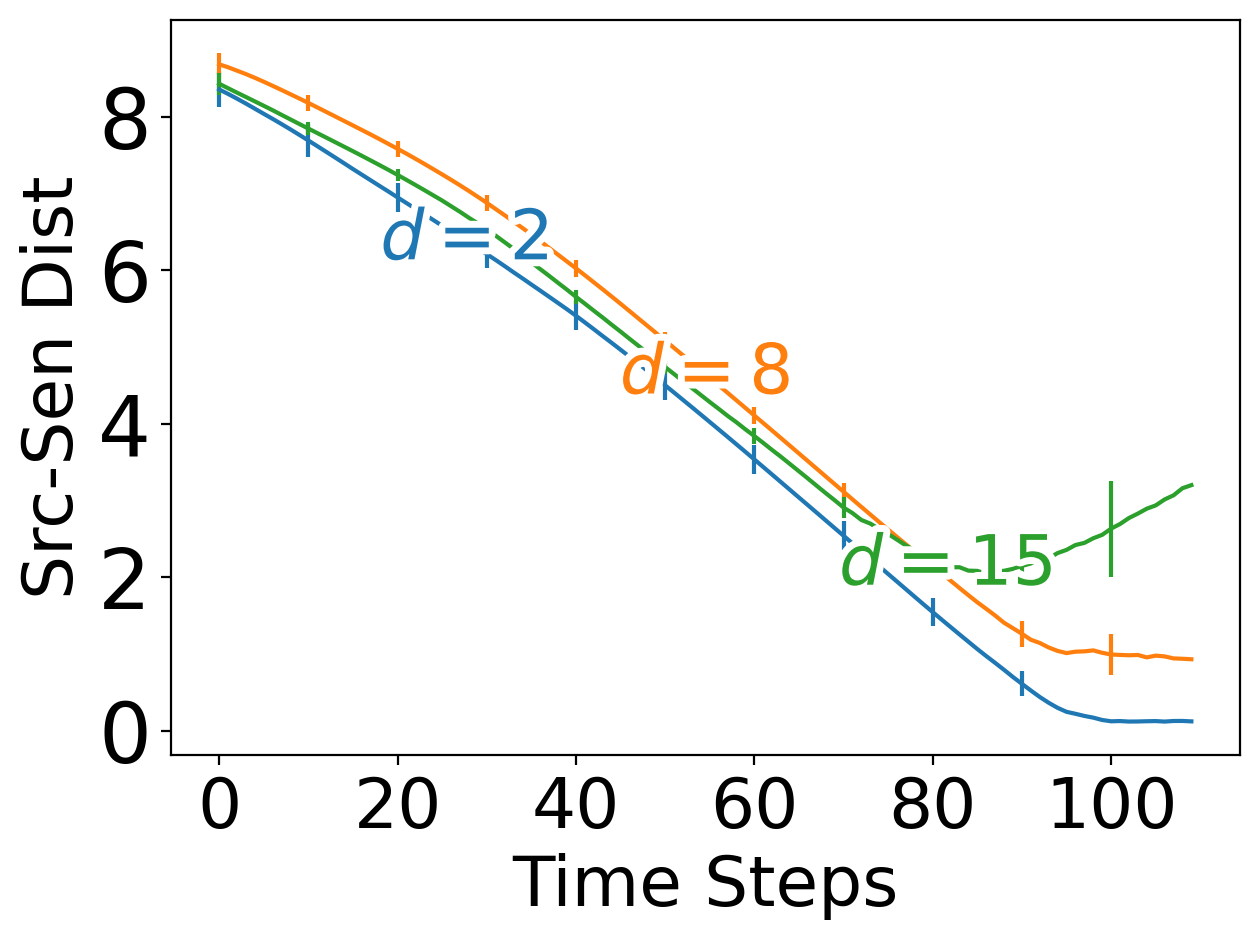

In [254]:
'''Plotting'''

filepath = "../Data/Connectivity_DSmall.pkl".format(deviation)
with open(filepath,'rb') as file:
    data=pkl.load(file)
    
t_end = 110
plt.figure(dpi=200)
for name,d in data.items():
    ps = np.array(d['p'])[:,:t_end,:,:]
    qhat = np.array(d['qhat'])[:,:t_end,:]
    q = np.array(d['q'])[:,:t_end,:]
     # qhat.shape=ps.shape=(N_trails,N_iter,space_dim)
    dist = np.linalg.norm(ps-q[:,:,np.newaxis,:],axis=-1)
    # dist.shape = (N_trails,N_iter,N_sen)
    # print(qhat.shape,dist.shape)
 
    
    ave_median_dist = np.mean(np.median(dist,axis=-1),axis=0)
    std_median_dist = np.std(np.median(dist,axis=-1),axis=0)
    N_iter=len(ave_median_dist)

    x = np.arange(N_iter)
  
    plt.errorbar(x,ave_median_dist,yerr=std_median_dist,label= r"$d=$"+"${}$".format(name),errorevery=10)

lines = plt.gca().get_lines()

labelLines(plt.gca().get_lines(), zorder=2.5,align=False,fontsize=25)    

# labelLines(lines[1:], yoffsets=0.01, align=True, backgroundcolor="none")

# labelLines(plt.gca().get_lines()[:3], zorder=2.5,align=False,fontsize=25)    

# l1 = lines[-1]
# labelLine(
#     l1,
#     100,
#     label=r'$v_{src}<0.1$',
#     ha="left",
#     va="bottom",
#     align=False,
#     backgroundcolor="none",
#     yoffset = -1.1,
#     fontsize = 25
# )
    
plt.ylabel('Src-Sen Dist',fontsize=25)
plt.xlabel('Time Steps',fontsize=25)
    # plt.legend(ncol =1 ,fontsize=15)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 30)

plt.tight_layout()
plt.savefig('../Figures/Connectivity_DSmall.png'.format(deviation))
plt.show()

# Large Deviation in initial guess

In [249]:
network_degrees = [2,5,8,15]
# network_degrees = [2,4,8,10]
# network_degrees = [20]
N_trails = 5
N_iter=200
n_sen=20
data={}

qhat_0 = np.array([3,1])


np.random.seed(SEED)

for d in network_degrees:
    data[d] = distributed_main(N_trails,n_sen,N_iter,network_degree = d,qhat_0=qhat_0)

/var/folders/4v/bq7m33xj6b9fm2jfm0ngdg3c0000gn/T/ipykernel_19377/394059718.py:8: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = np.array(nx.adjacency_matrix(G).todense().astype(float))


Time: 2.0292789936065674
Time: 2.7673051357269287
Time: 3.9150359630584717
Time: 4.357675075531006


In [250]:
filepath = "../Data/Connectivity_DLarge.pkl".format(deviation)
with open(filepath,'wb') as file:
    pkl.dump(data,file)


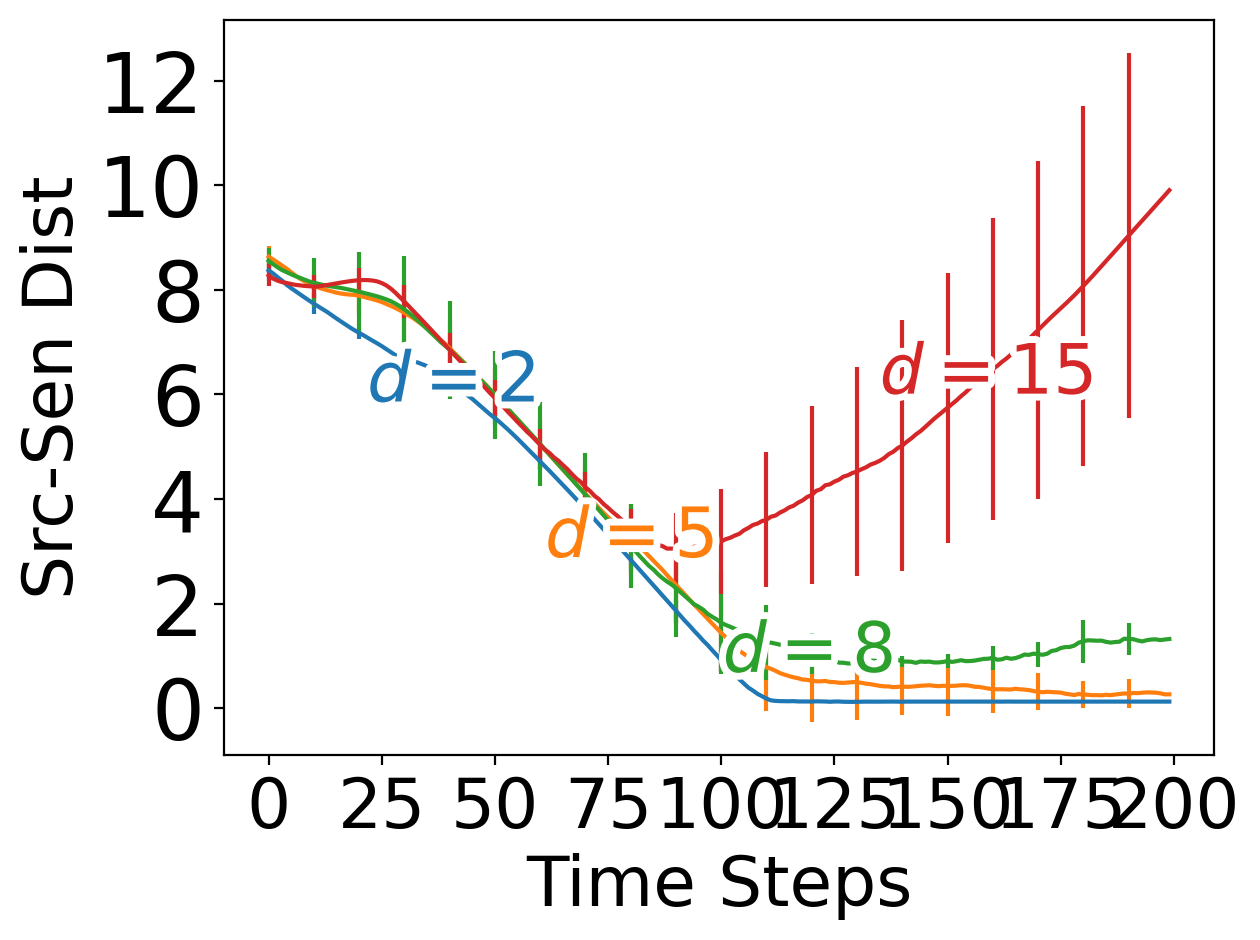

In [251]:
'''Plotting'''

filepath = "../Data/Connectivity_DLarge.pkl".format(deviation)
with open(filepath,'rb') as file:
    data=pkl.load(file)
    
t_end = 200
plt.figure(dpi=200)
for name,d in data.items():
    ps = np.array(d['p'])[:,:t_end,:,:]
    qhat = np.array(d['qhat'])[:,:t_end,:]
    q = np.array(d['q'])[:,:t_end,:]
     # qhat.shape=ps.shape=(N_trails,N_iter,space_dim)
    dist = np.linalg.norm(ps-q[:,:,np.newaxis,:],axis=-1)
    # dist.shape = (N_trails,N_iter,N_sen)
    # print(qhat.shape,dist.shape)
 
    
    ave_median_dist = np.mean(np.median(dist,axis=-1),axis=0)
    std_median_dist = np.std(np.median(dist,axis=-1),axis=0)
    N_iter=len(ave_median_dist)

    x = np.arange(N_iter)
  
    plt.errorbar(x,ave_median_dist,yerr=std_median_dist,label= r"$d=$"+"${}$".format(name),errorevery=10)

lines = plt.gca().get_lines()

labelLines(plt.gca().get_lines(), zorder=2.5,align=False,fontsize=25)    

# labelLines(lines[1:], yoffsets=0.01, align=True, backgroundcolor="none")

# labelLines(plt.gca().get_lines()[:3], zorder=2.5,align=False,fontsize=25)    

# l1 = lines[-1]
# labelLine(
#     l1,
#     100,
#     label=r'$v_{src}<0.1$',
#     ha="left",
#     va="bottom",
#     align=False,
#     backgroundcolor="none",
#     yoffset = -1.1,
#     fontsize = 25
# )
    
plt.ylabel('Src-Sen Dist',fontsize=25)
plt.xlabel('Time Steps',fontsize=25)
    # plt.legend(ncol =1 ,fontsize=15)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 30)

plt.tight_layout()
plt.savefig('../Figures/Connectivity_DLarge.png'.format(deviation))
plt.show()